In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
def running_mean(X,n=10):
    return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
#
#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200724.pkl'

In [3]:
# n_cpus:
n_cpus = 1
if 'SLURM_JOB_ID' in os.environ.keys():
    # running in SLURM...
    if 'SLURM_JOB_CPUS_PER_NODE' in os.environ.keys():
        n_cpus = max( int(os.environ['SLURM_JOB_CPUS_PER_NODE']), 1)
    else:
        n_cpus = 1
else:
    #n_cpus = min(8, mpp.cpu_count())
    # huh? we want at least 1, then about 3/4 of all *actual* cpus. parallelizing onto hyperthreads
    #. does not usually gain much (if anything)
    n_cpus = max(1, int((mpp.cpu_count()/2)*.8))
#
# or specify here:
#n_cpus = 4
#
print('** n_cpus: ', n_cpus)

** n_cpus:  4


In [4]:
#end_dtm = dtm.datetime.now()+dtm.timedelta(days=1)
N_report_len = 180
end_dtm = dtm.datetime(2023,10,31)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
ft_min = mpd.date2num(start_date)
ft_max = mpd.date2num(end_date)
#partition='serc'
partition=None
group='oneillm'
#group='edunham'
sacct_h5_file = f'sacct_data/sacct_p{str(partition).upper()}_g{str(group).upper()}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file: {sacct_h5_file}')
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
print(f'*** h5_exists({sacct_h5_file}): {os.path.isfile(sacct_h5_file)}')
#

*** dates: 2023-05-04 - 2023-10-31
*** sacct_h5_file: sacct_data/sacct_pNONE_gONEILLM_20230504_20231031.h5
*** h5_exists(sacct_data/sacct_pNONE_gONEILLM_20230504_20231031.h5): True


In [5]:
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus,
                                          end_date=str(end_date), keep_raw_data=False)
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** Creating SACCT object from HDF5 sacct_data/sacct_pNONE_gONEILLM_20230504_20231031.h5
**  ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [8]:
# get a partition obj too:
#print('*** Fetching SACCT data directly')
partition_onm = 'oneillm'
group_onm = None
h5_oneillm = f'sacct_data/sacct_p{str(partition_onm).upper()}_g{str(group_onm).upper()}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'

#
if os.path.isfile(h5_oneillm):
    print('*** Creating SACCT object from HDF5 {}'.format(h5_oneillm))
    SACCT_oneillm = hpc_lib.SACCT_data_from_h5(h5_oneillm, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:

    SACCT_oneillm = hpc_lib.SACCT_data_direct(group=group_onm, partition=partition_onm, 
                                              start_date=str(start_date),
                                          n_cpu=n_cpus,
                                          end_date=str(end_date), keep_raw_data=False)
    print(f'** writing HDF5: {h5_oneillm}')
    SACCT_oneillm.write_hdf5(h5_oneillm)



***  2023-05-04 00:00:00+00:00 <class 'datetime.datetime'> 2023-10-31 00:00:00+00:00 <class 'datetime.datetime'>
*** DEBUG: Now execute load_sacct_data(); options_str= --partition=oneillm  --delimiter="|" 
*** DEBUG: load_sacct_data() executed. Compute calc_jobs_summary()
*** DEBUG: data stuff:  10507 (numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('Account', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('ReqMem', '<f8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'O'), ('Suspended', 'O'), ('ReqTRES', 'O'), ('AllocTRES', 'O'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent',

/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3309: RuntimeWarning: All-NaN slice encountered
  jobs_summary[cls][k] = tuple([f(sub_data[n2]) for (n1, n2, f) in js_col_f])
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3131: RuntimeWarning: All-NaN slice encountered
  ('NTasks',    'NTasks', lambda x: numpy.nanmax(x).astype(int)),\
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3131: RuntimeWarning: invalid value encountered in cast
  ('NTasks',    'NTasks', lambda x: numpy.nanmax(x).astype(int)),\


** writing HDF5: sacct_data/sacct_pONEILLM_gNONE_20230504_20231031.h5
*** DEBUG: updating column [index], type=<i8
*** DEBUG: updating column [User], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Group], type=('|S7', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [GID], type=('|S6', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Account], type=('|S7', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobID], type=('|S34', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobIDRaw], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Partition], type=('|S7', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [State], type=('|S19', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Timelimit], type=<f8
*** DEBUG: updating column [NCPUS], type=<i8
*** DEBUG: updating column [ReqMem], type=<f8
*** DEBUG: updating column [NNodes], type=<i8
*** DEBUG: updating column [Submit], type=<f8
*** DEBUG: updating column [E

In [9]:
# oneillm users:
print('** ', numpy.unique(SACCT_oneillm['User']))

**  ['arunbk' 'haofu' 'ipshi91' 'oneillm' 'regirock']


In [6]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl]))
                                                   for cl in ['Start', 'Submit'] ]))
print('** cols: ', SACCT_obj.jobs_summary.dtype.names)

*** max_submit: 2023-10-30 07:38:32+00:00, max_start: 2023-10-30 07:37:22+00:00
** cols:  ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [7]:
# NOTE: add this to the __init__. would be nice to refactor the code a bit to better handle inheritance.
if not 'chunk_size' in SACCT_obj.__dict__.keys():
    print('*** assigning chunk_size: ', chunk_size)
    SACCT_obj.chunk_size=1000

In [12]:
print('*** ', len(SACCT_obj.jobs_summary['Group']))
print('*** ', len(SACCT_oneillm['Group']))

***  5207
***  3487


** quantiles: {} [  2.75  58.   253.   583.1 ]
**  182.1876
**  58.0
**  243.78764284975563


Text(0.5, 1.0, 'CDF of CPU Usage: partitoin=oneillm ')

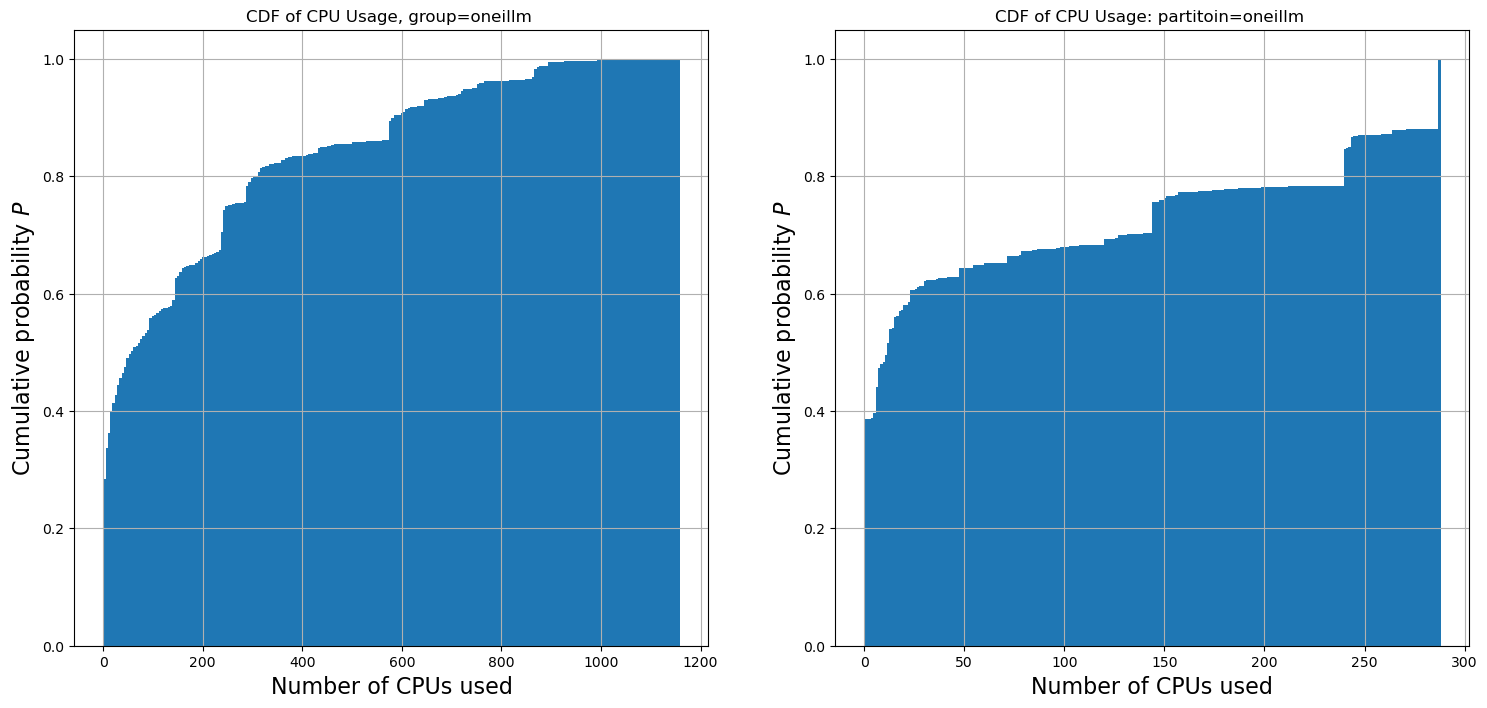

In [13]:
#N = 5456.
N=1
quantiles = numpy.quantile(SACCT_obj.cpu_usage['N_cpu'], [.25, .5, .75, .9])
quantiles_onm = numpy.quantile(SACCT_oneillm.cpu_usage['N_cpu'], [.25, .5, .75, .9])

print('** quantiles: {}', quantiles/N)
print('** ', numpy.mean(SACCT_obj.cpu_usage['N_cpu'])/N)
print('** ', numpy.median(SACCT_obj.cpu_usage['N_cpu'])/N)
print('** ', numpy.std(SACCT_obj.cpu_usage['N_cpu'])/N)
#
# get some jobs_summary stats....
fg = plt.figure(figsize=(18,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.grid()
hh = ax1.hist(SACCT_obj.cpu_usage['N_cpu']/N, bins=250, cumulative=True, density=True)
ax1.set_xlabel('Number of CPUs used', size=16)
ax1.set_ylabel('Cumulative probability $P$', size=16)
ax1.set_title('CDF of CPU Usage, group=oneillm ')

ax2.grid()
hh = ax2.hist(SACCT_oneillm.cpu_usage['N_cpu']/N, bins=250, cumulative=True, density=True)
ax2.set_xlabel('Number of CPUs used', size=16)
ax2.set_ylabel('Cumulative probability $P$', size=16)
ax2.set_title('CDF of CPU Usage: partitoin=oneillm ')

In [9]:
#
cpu_usage = SACCT_obj.cpu_usage
#cpu_weekly = SACCT_obj.cpu_weekly
#
#cpu_usage = SACCT_obj.active_jobs_cpu()
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=None)

In [10]:
print('** ', len(cpu_usage))
print('** \n', cpu_usage[0:10])


**  5000
** 
 [(19481.        , 1., 240.) (19481.0360072 , 1., 240.)
 (19481.0720144 , 1., 240.) (19481.1080216 , 1., 240.)
 (19481.14402881, 1., 240.) (19481.18003601, 1., 240.)
 (19481.21604321, 1., 240.) (19481.25205041, 1., 240.)
 (19481.28805761, 1., 240.) (19481.32406481, 1., 240.)]


/tmp/ipykernel_29213/103932961.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(19450.0, 0, '2023-4-3'),
 Text(19475.0, 0, '2023-4-28'),
 Text(19500.0, 0, '2023-5-23'),
 Text(19525.0, 0, '2023-6-17'),
 Text(19550.0, 0, '2023-7-12'),
 Text(19575.0, 0, '2023-8-6'),
 Text(19600.0, 0, '2023-8-31'),
 Text(19625.0, 0, '2023-9-25'),
 Text(19650.0, 0, '2023-10-20'),
 Text(19675.0, 0, '2023-11-14')]

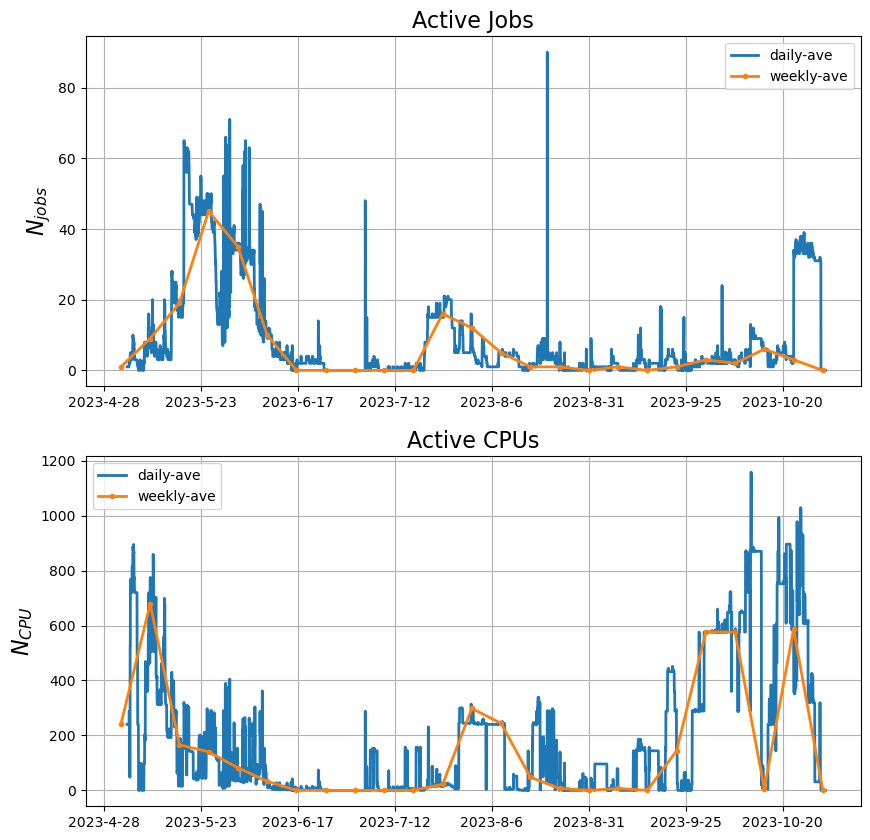

In [12]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,1,2, sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='', label='daily-ave')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.', label='weekly-ave')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='', label='daily-ave')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.', label='weekly-ave')
#

ax1.set_title('Active Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
ax1.legend(loc=0)
#
ax2.set_title('Active CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)
ax2.legend(loc=0)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
# fix_to_ascii(s)
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(s.get_text()))) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



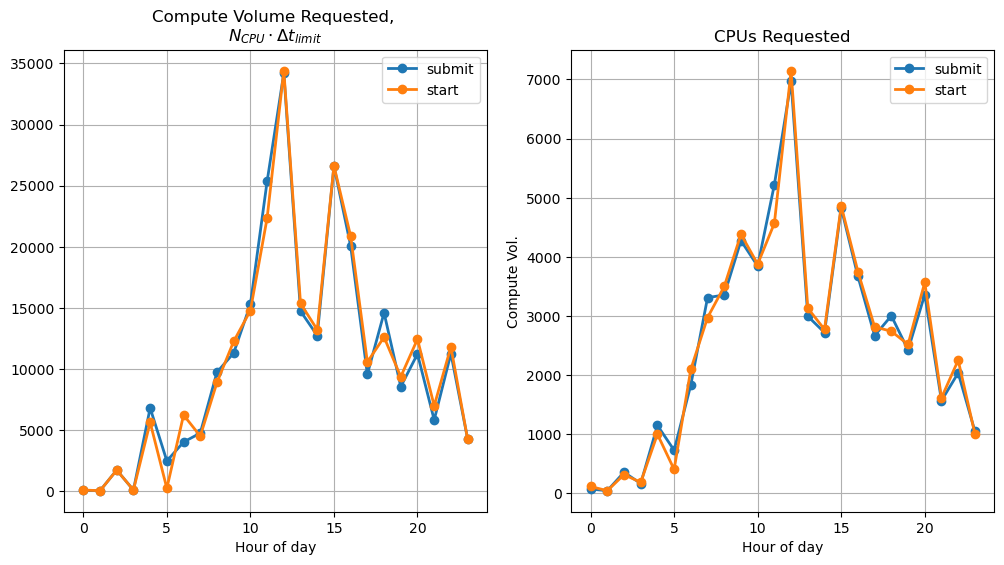

In [20]:
qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

Text(0.5, 0.98, 'Instantaneous Usage')

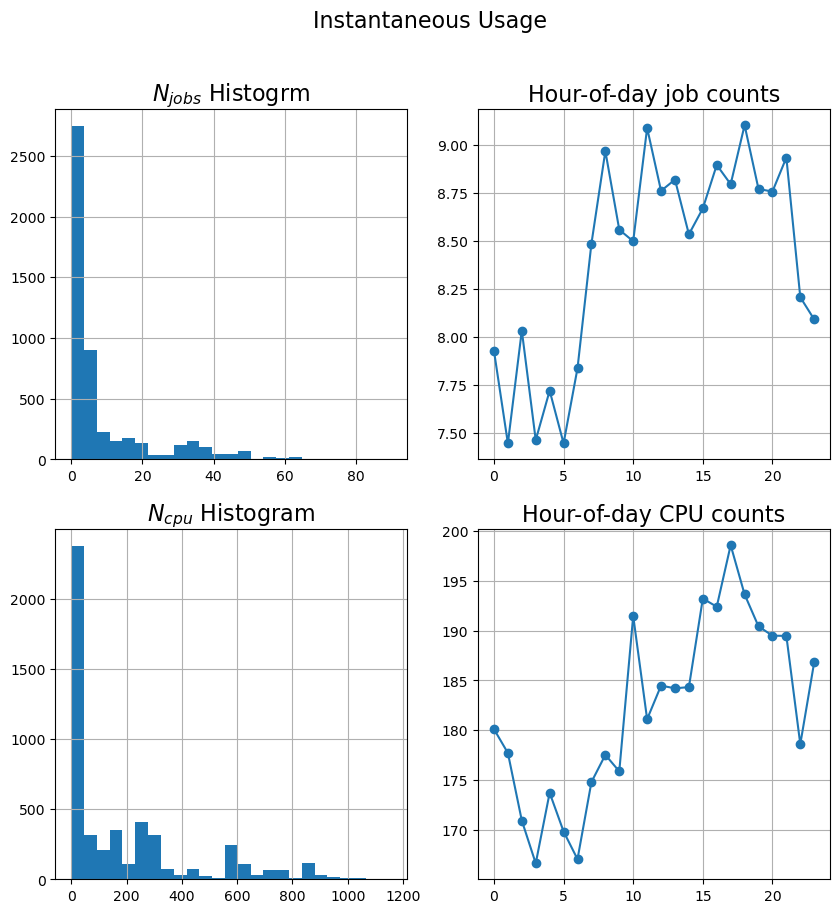

In [13]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
axs = [ax1, ax2, ax3, ax4]
[ax.grid() for ax in axs]
#
cpu_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_cpu']]).T)
jobs_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_jobs']]).T)

hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o')

hh3 = ax3.hist(cpu_usage['N_cpu'], bins=25)
ax4.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o')

#ax1.set_ylim(-5., 200)
ax1.set_title('$N_{jobs}$ Histogrm', size=16)
ax2.set_title('Hour-of-day job counts', size=16)
ax3.set_title('$N_{cpu}$ Histogram', size=16)
ax4.set_title('Hour-of-day CPU counts', size=16)
#
plt.suptitle('Instantaneous Usage', size=16)

In [14]:
#TODO: looking into best way to store class meta data for HDF5 reloads.
#
weekly_hours = SACCT_obj.get_cpu_hours(bin_size=7, n_points=5000, t_min=mpd.datestr2num('2021-12-01'),
                                       t_max=mpd.datestr2num('2022-05-24'))

daily_hours = SACCT_obj.get_cpu_hours(bin_size=1, n_points=5000, t_min=mpd.datestr2num('2021-12-01'),
                                       t_max=mpd.datestr2num('2022-05-24'))

*** DEBUG t_now: 19660.71207986559, t_max: 19660.318425925925


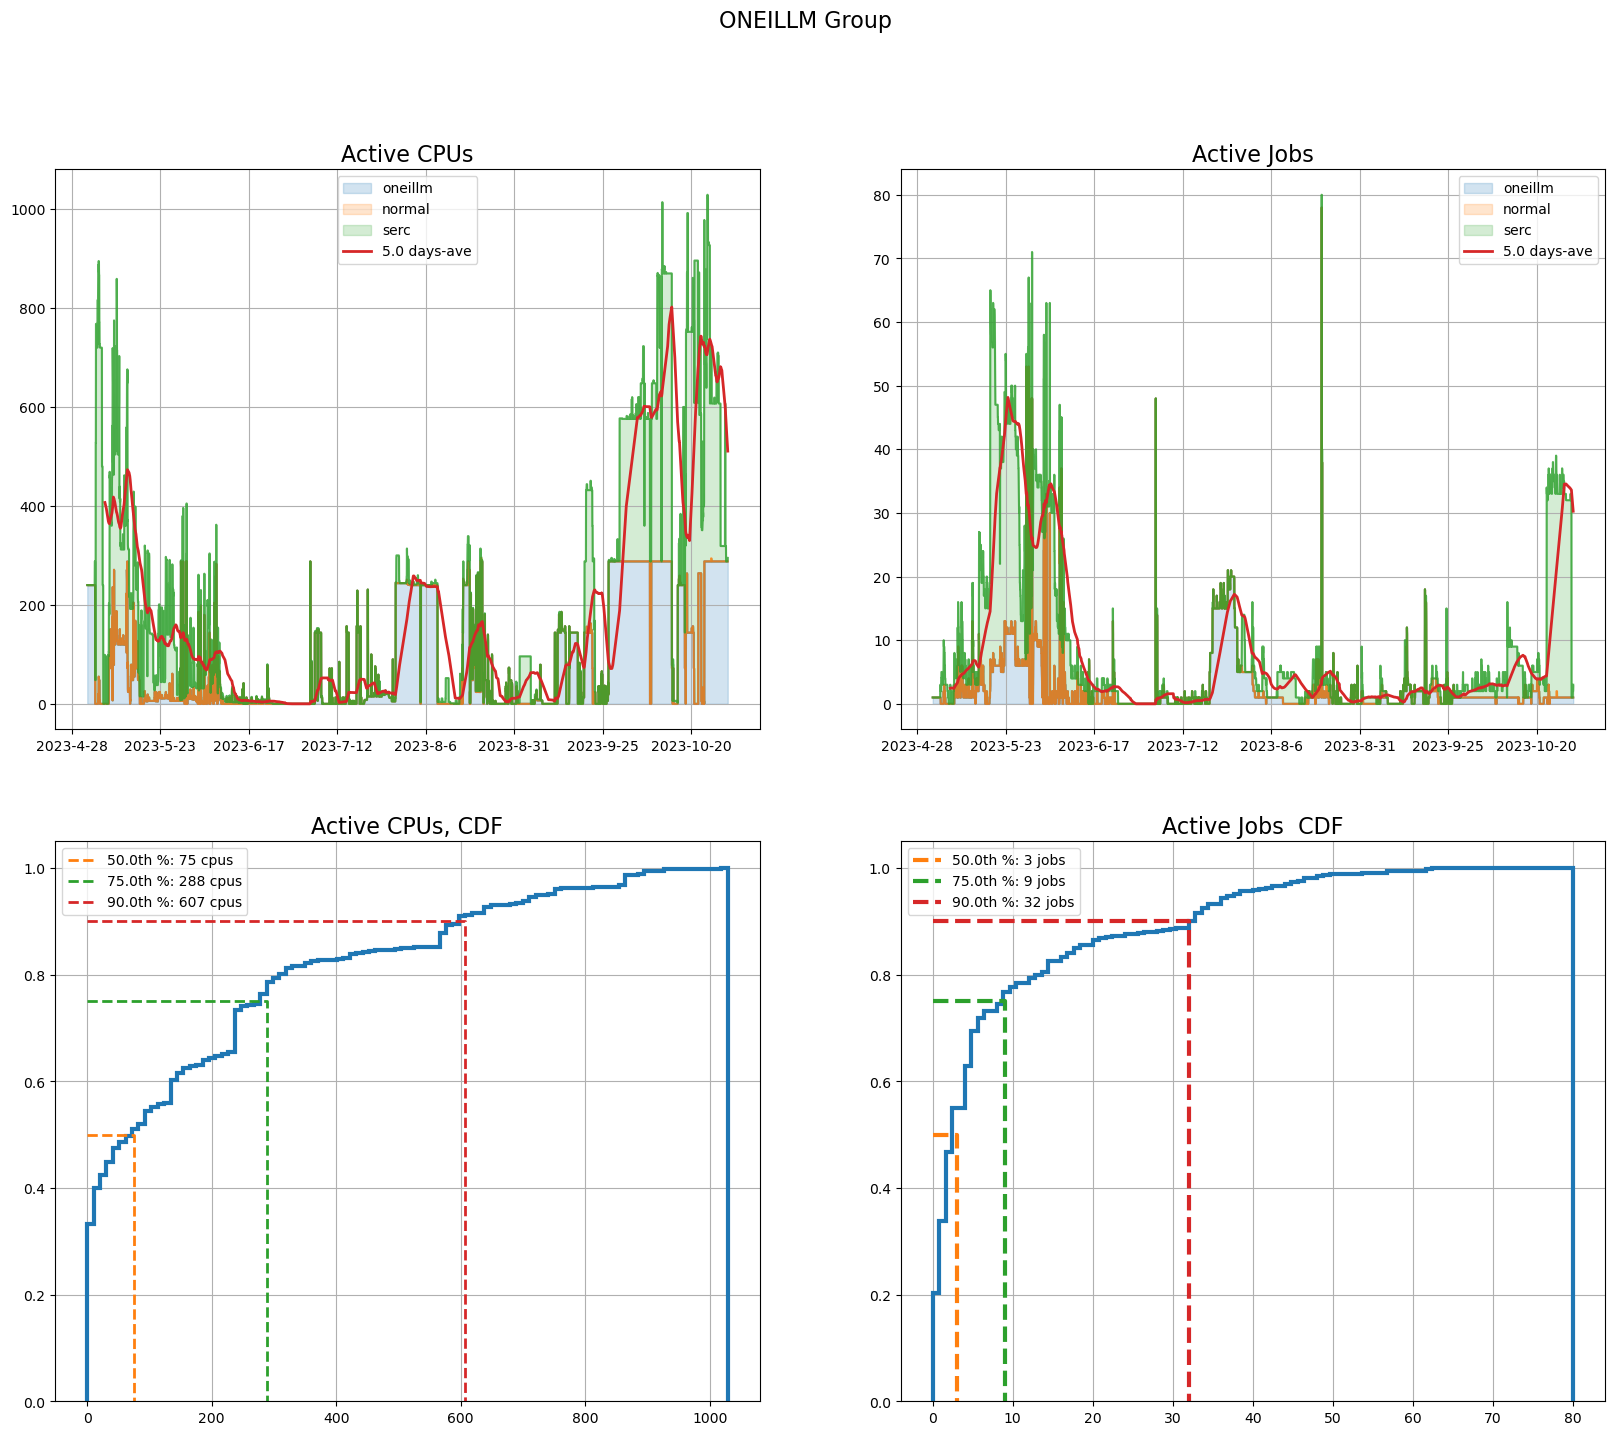

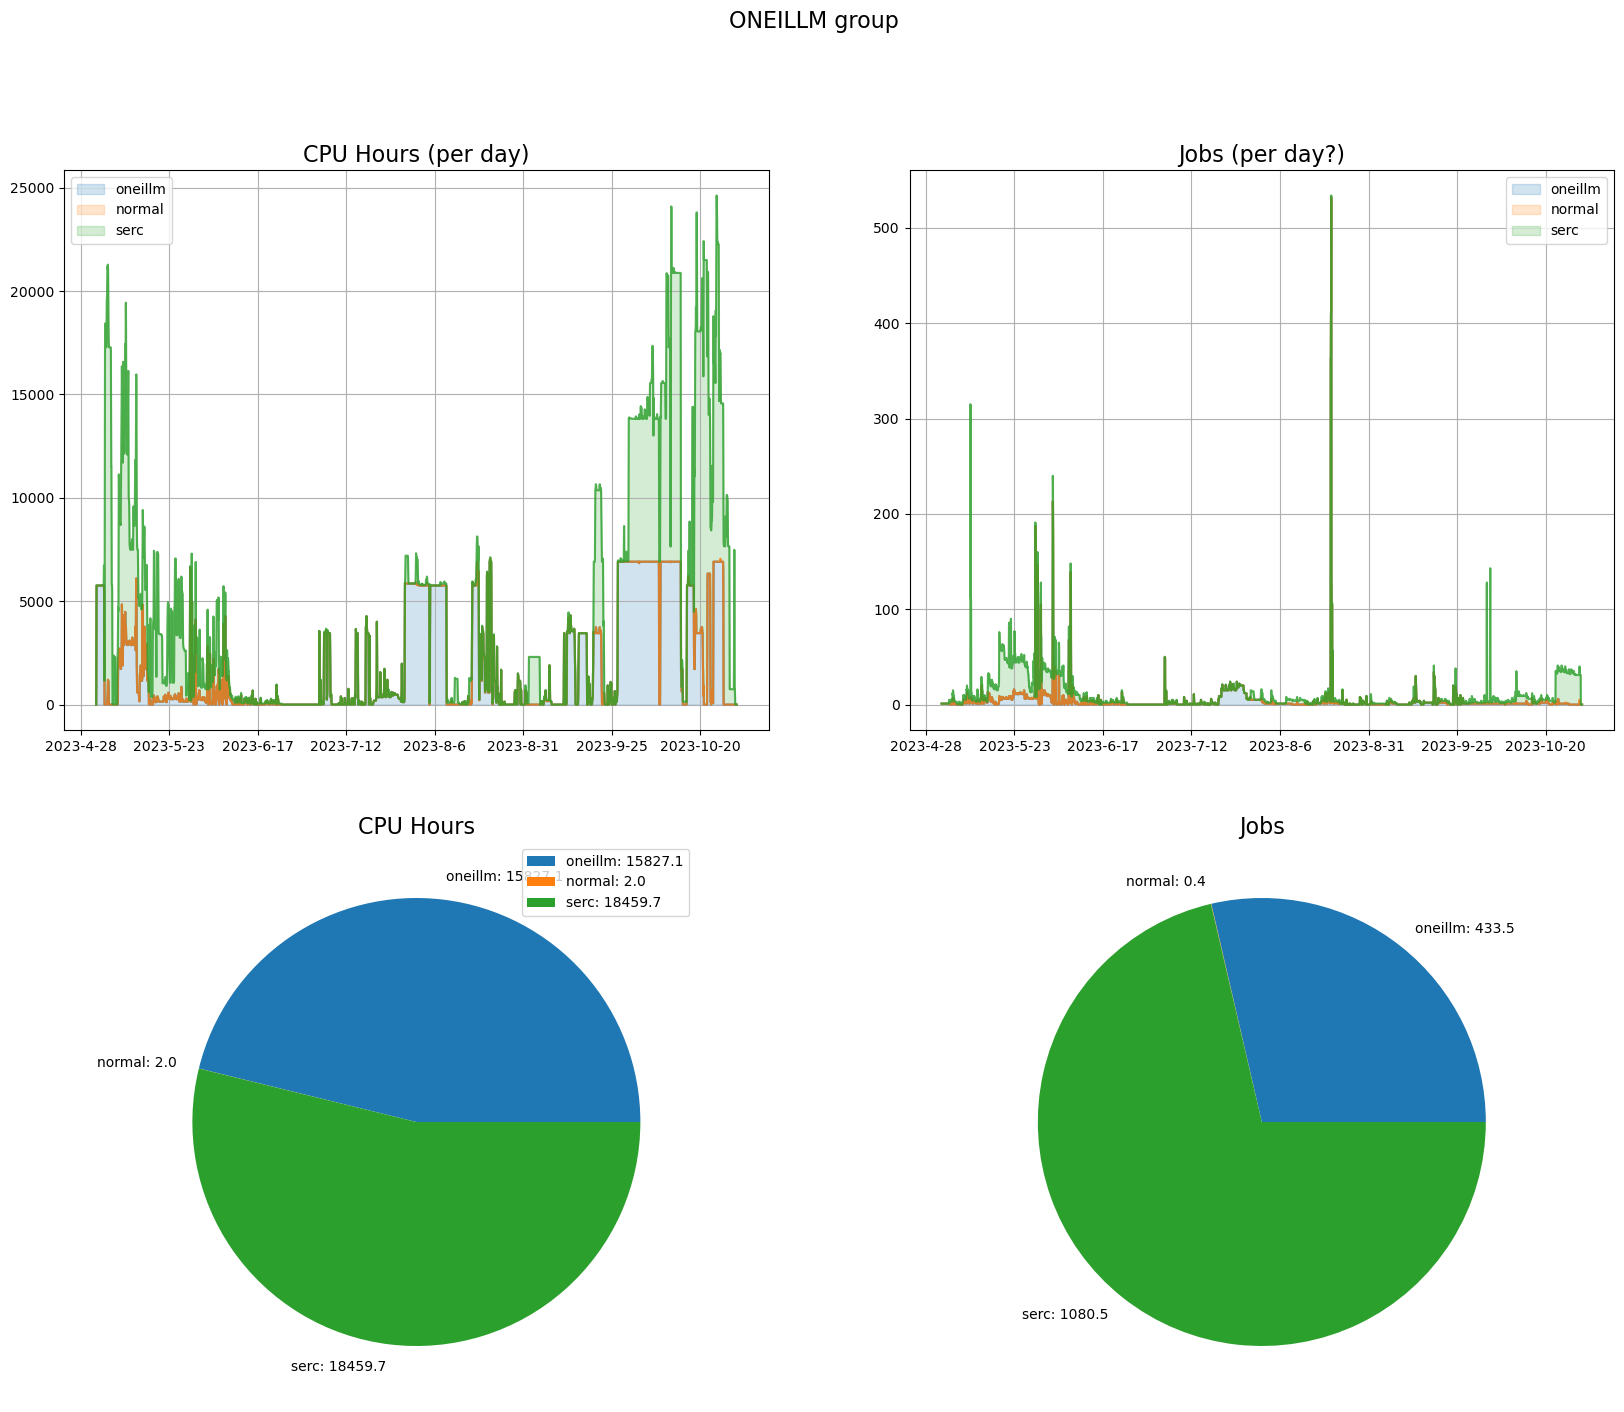

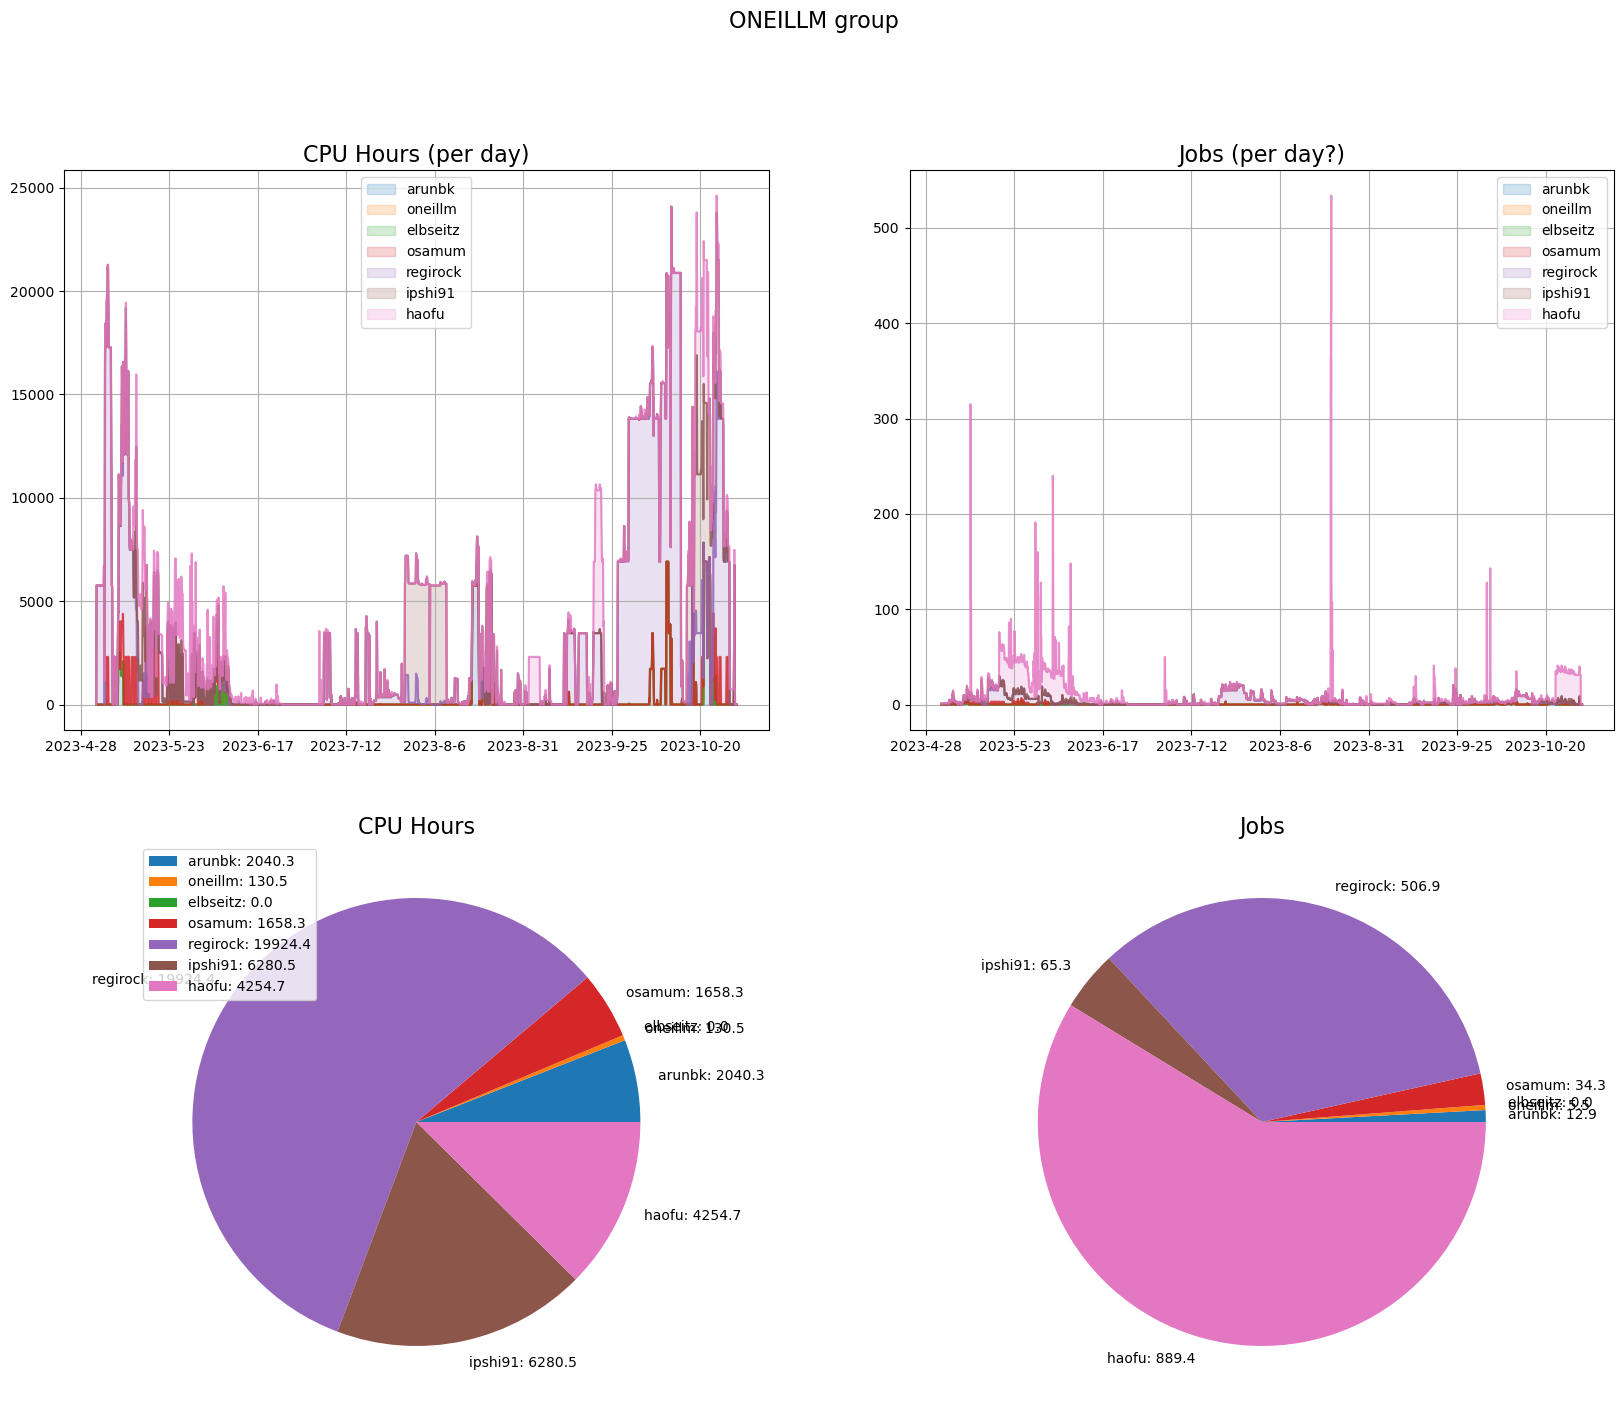

In [16]:
fg = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(group_by='Partition')
s = fg.suptitle('ONEILLM Group', size=16)
fg.axes[2].legend(loc=0)
#
fg = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='Partition')
fg.suptitle('ONEILLM group', size=16)
fg.axes[2].legend(loc=0)

fg = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='User')
fg.suptitle('ONEILLM group', size=16)
fg.axes[2].legend(loc=0)

*** DEBUG t_now: 19660.406715270787, t_max: 19657.936712962965


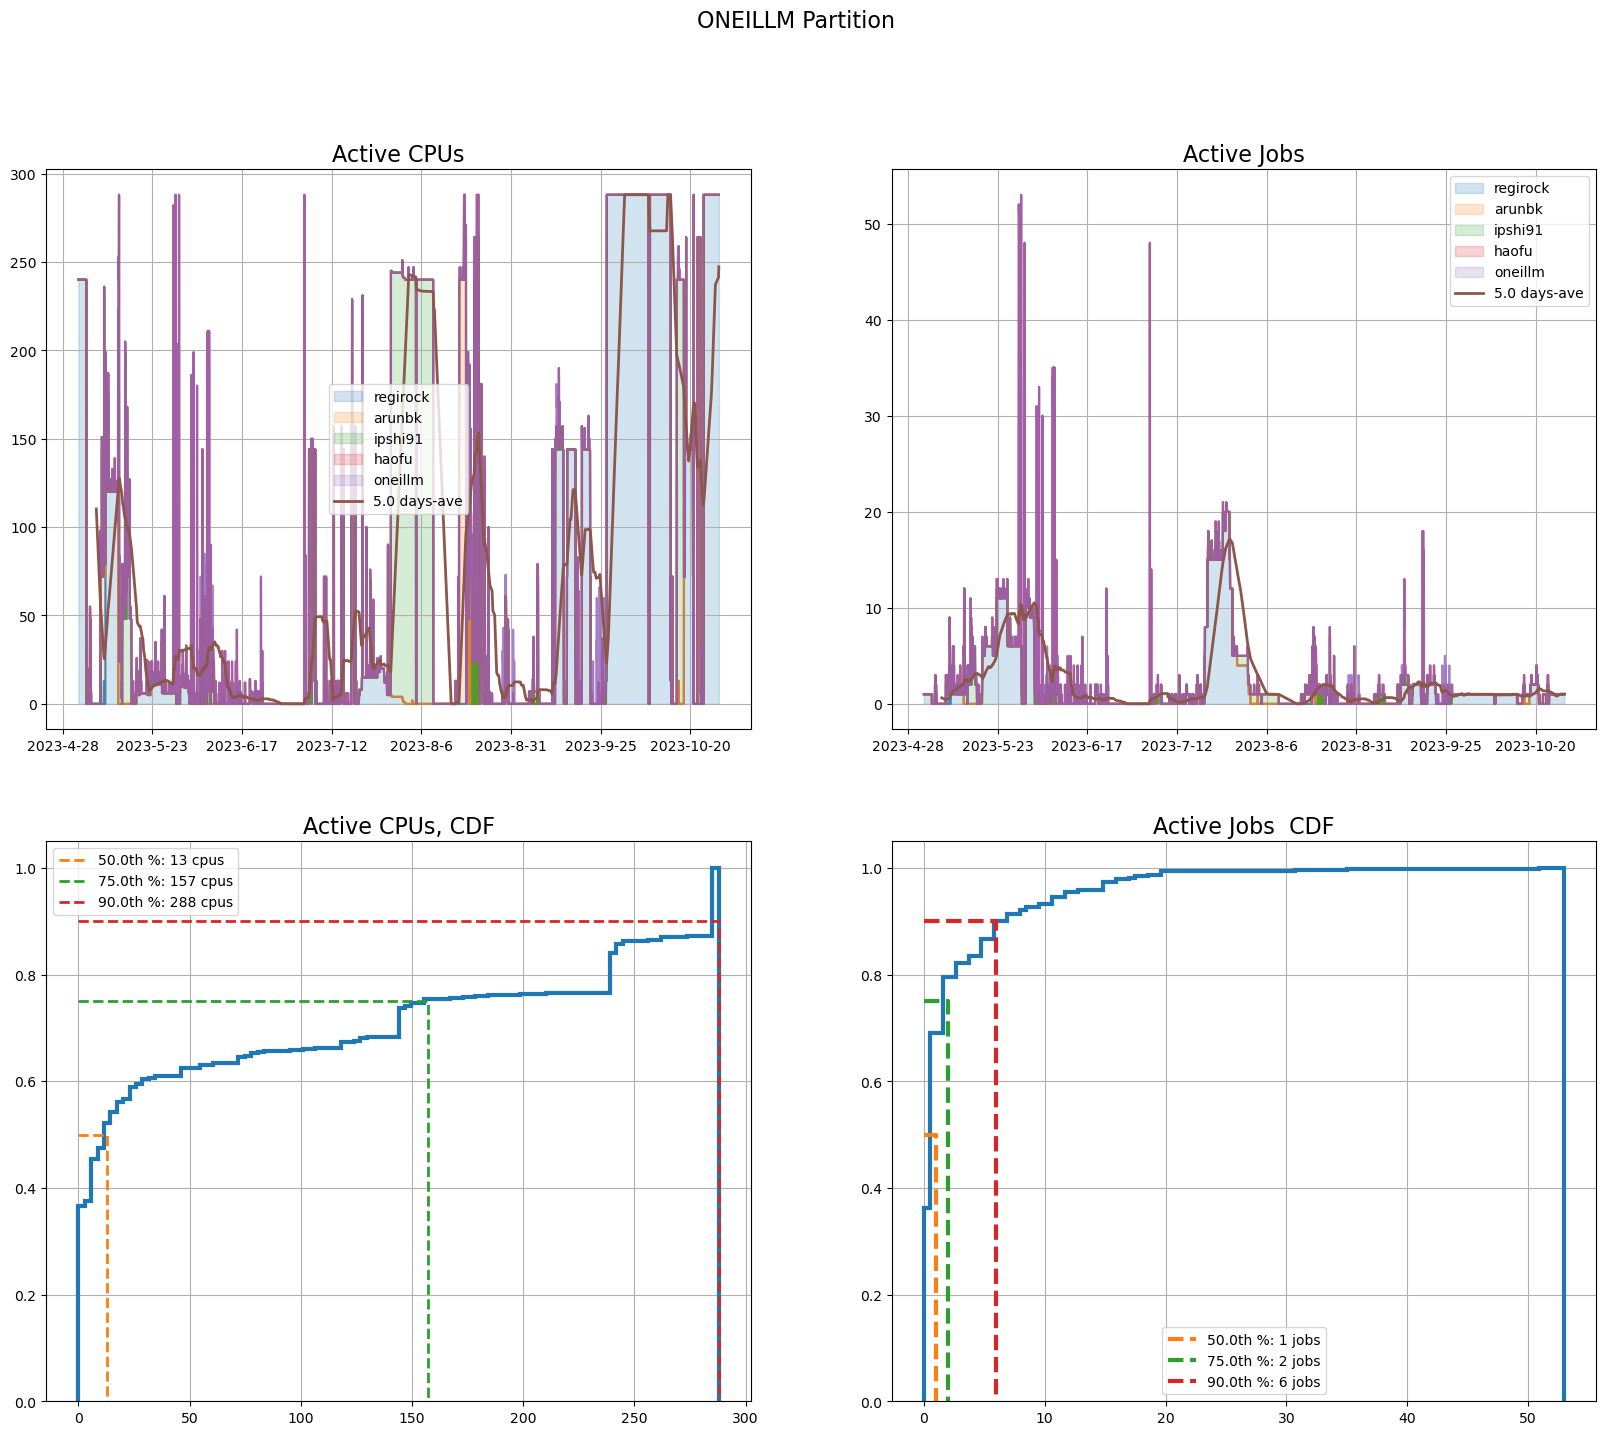

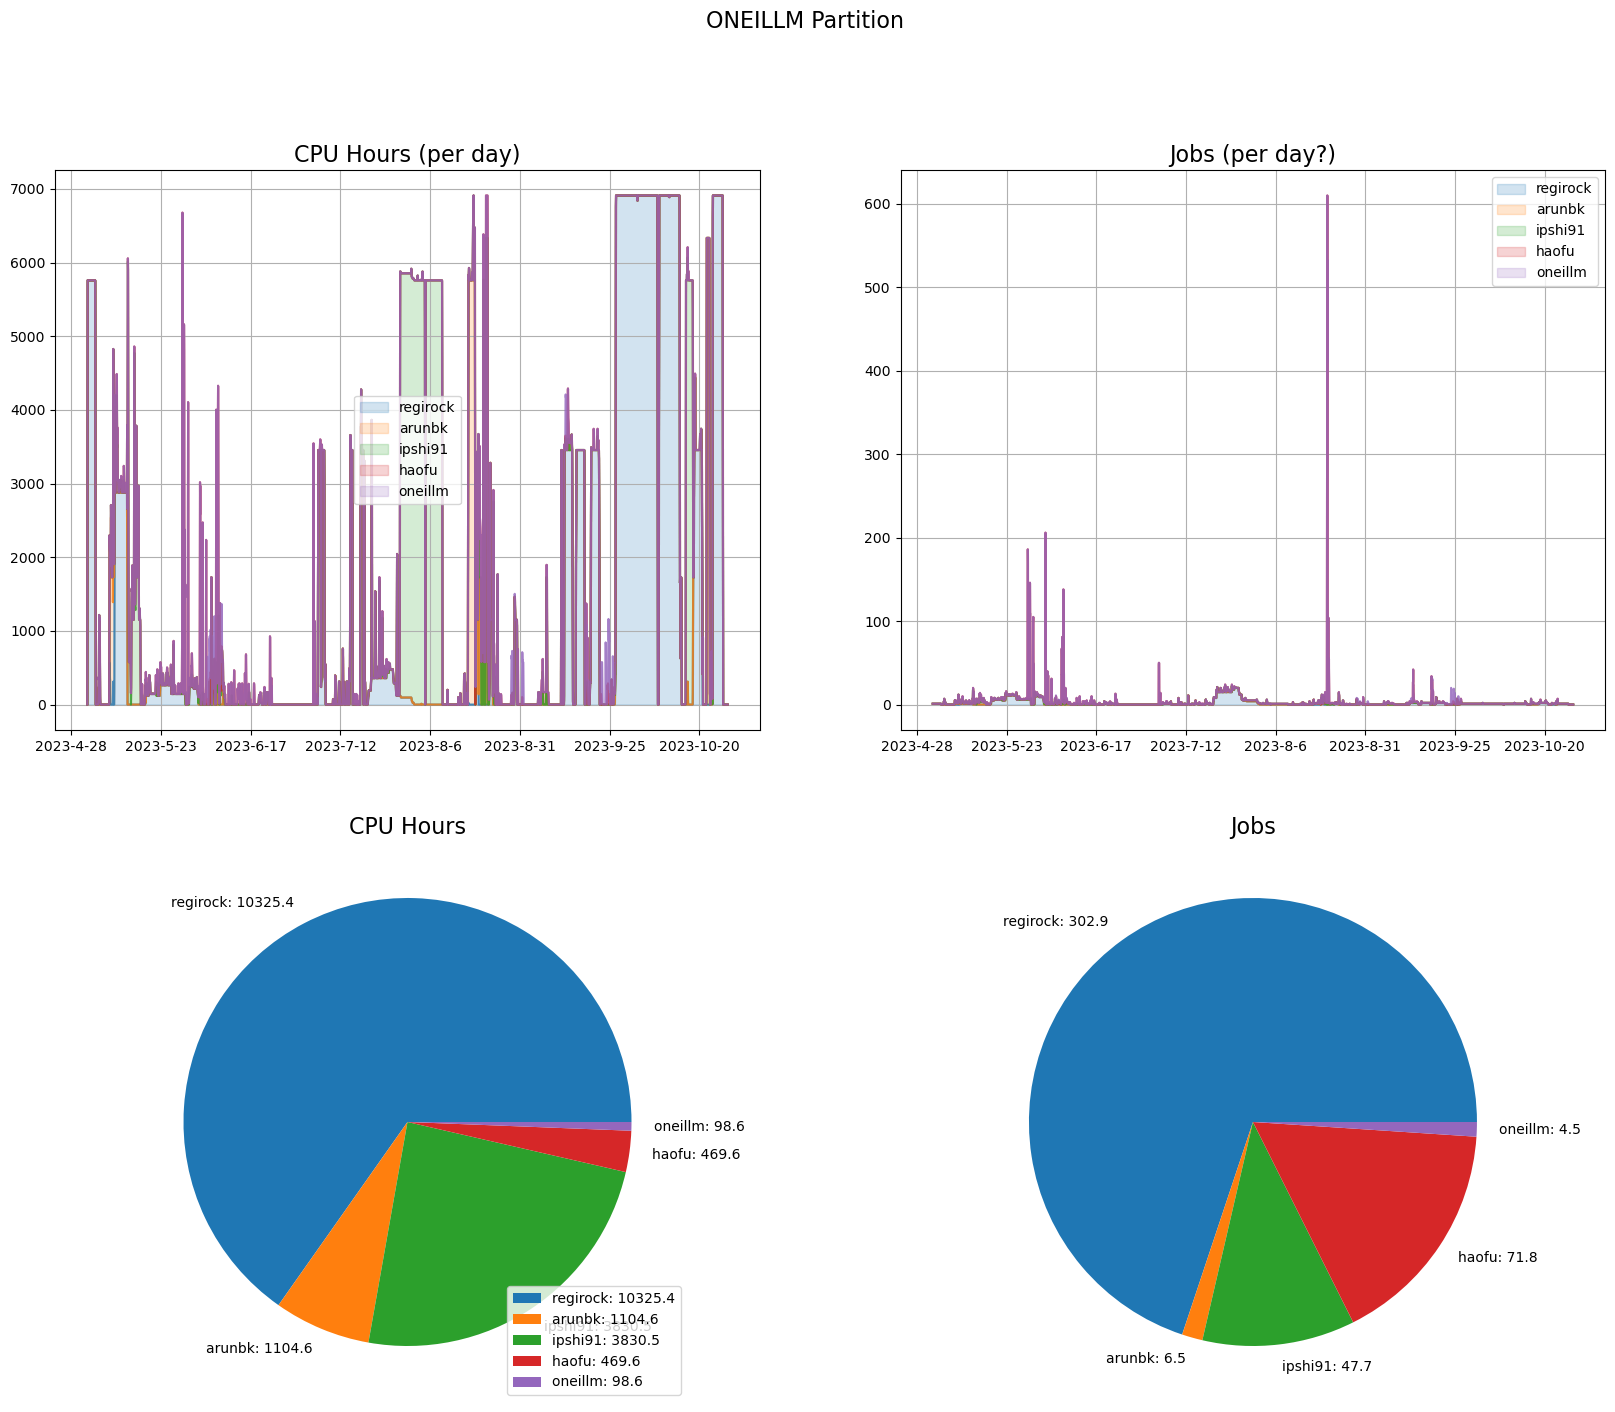

In [25]:
fg = SACCT_oneillm.report_activecpus_jobs_layercake_and_CDFs(group_by='User')
s = fg.suptitle('ONEILLM Partition', size=16)
fg.axes[2].legend(loc=0)
#
# {'autopct':'%1.1f%%'}
fg = SACCT_oneillm.report_cpuhours_jobs_layercake_and_pie(group_by='User', wedgeprops=None)
fg.suptitle('ONEILLM Partition', size=16)
fg.axes[2].legend(loc=0)

In [26]:
unique_users = numpy.unique(SACCT_obj['User'])
print('** unique_users, Oneillm Group: ', numpy.unique(SACCT_obj['User']))
print('** unique_users, Oneillm Partition: ', numpy.unique(SACCT_oneillm['User']))

** unique_users, Oneillm Group:  ['arunbk' 'elbseitz' 'haofu' 'ipshi91' 'oneillm' 'osamum' 'regirock']
** unique_users, Oneillm Partition:  ['arunbk' 'haofu' 'ipshi91' 'oneillm' 'regirock']


**  [('arunbk',  1104.62196759) ('haofu',   469.60697917)
 ('ipshi91',  3830.47303241) ('oneillm',    98.60027778)
 ('regirock', 10325.40591435)]
*** 
arunbk :: 1104.6219675925925
haofu :: 469.60697916666663
ipshi91 :: 3830.4730324074076
oneillm :: 98.60027777777778
regirock :: 10325.405914351853
idle :: 36011.2918287037
** ix:  [ True  True  True  True  True False]


Text(0.5, 1.0, '(center shows idle time)')

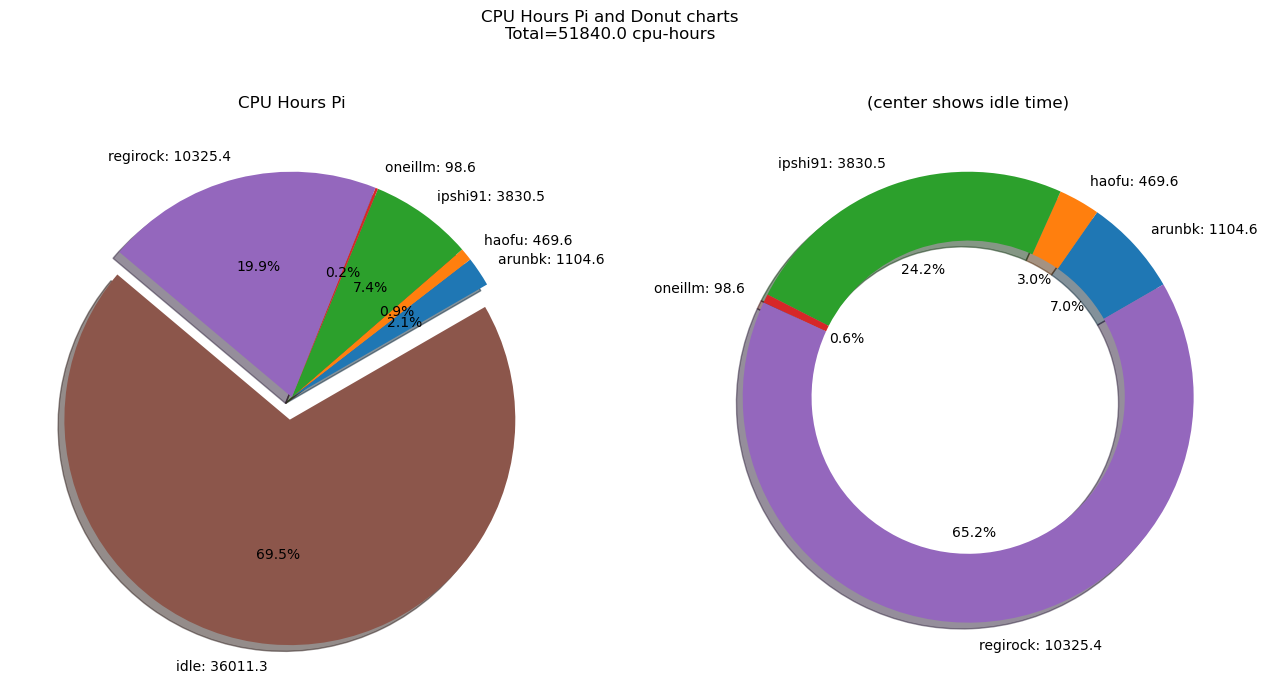

In [51]:
null_name = 'idle'
pi_users_data = hpc_lib.get_pie_slices(sum_data=SACCT_oneillm['Elapsed']*SACCT_oneillm['NCPUS'], slice_data=SACCT_oneillm['User'])
print('** ', pi_users_data)
total_time = (mpd.date2num(end_dtm) - mpd.date2num(start_date))*(12*24)
idle_time = total_time - numpy.sum(pi_users_data['value'])
pi_users_data = numpy.append(pi_users_data, numpy.array([(null_name, idle_time)], dtype=pi_users_data.dtype))
#
print('*** ')
for n,x in pi_users_data:
    print(f'{n} :: {x}')
#
explode = numpy.zeros(len(pi_users_data))
explode[-1] = .1
#
fg = plt.figure(figsize=(16,8))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
lbls = [f'{nm}: {vl:.1f}' for nm,vl in pi_users_data]
#
cntr = (0., 0.)
pie_data = ax1.pie(pi_users_data['value'], labels=lbls, autopct='%1.1f%%',
                   shadow=True, explode=explode, startangle=30., wedgeprops={'width':1.})
# crcl = plt.Circle(xy=cntr, radius=.2, color='w')
# ax1.add_artist(crcl)
ix = pi_users_data['name'].astype(str) != null_name
print('** ix: ', ix)
pct_used = (total_time - idle_time)/total_time
donut = ax2.pie((pi_users_data['value'])[ix], 
                labels=[s for s,b in zip(lbls,ix) if b==True], autopct='%1.1f%%',
                   shadow=True, explode=explode[ix], startangle=30., wedgeprops={'width':pct_used} )
#
fg.suptitle(f'CPU Hours Pi and Donut charts\nTotal={total_time} cpu-hours')
ax1.set_title('CPU Hours Pi')
ax2.set_title('(center shows idle time)')

** partition: b'oneillm'
** partition: b'normal'
** partition: b'serc'
*** my_partitions: {'serc': {}, 'oneillm': {}, 'normal': {}}
**  serc
**  oneillm
**  normal
*** lbls:  ['19450', '19475', '19500', '19525', '19550', '19575', '19600', '19625', '19650', '19675']


/tmp/ipykernel_29213/3122578516.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls)


(-1.0999968164181928,
 1.0999994512392604,
 -1.0999993061344693,
 1.0999999669587843)

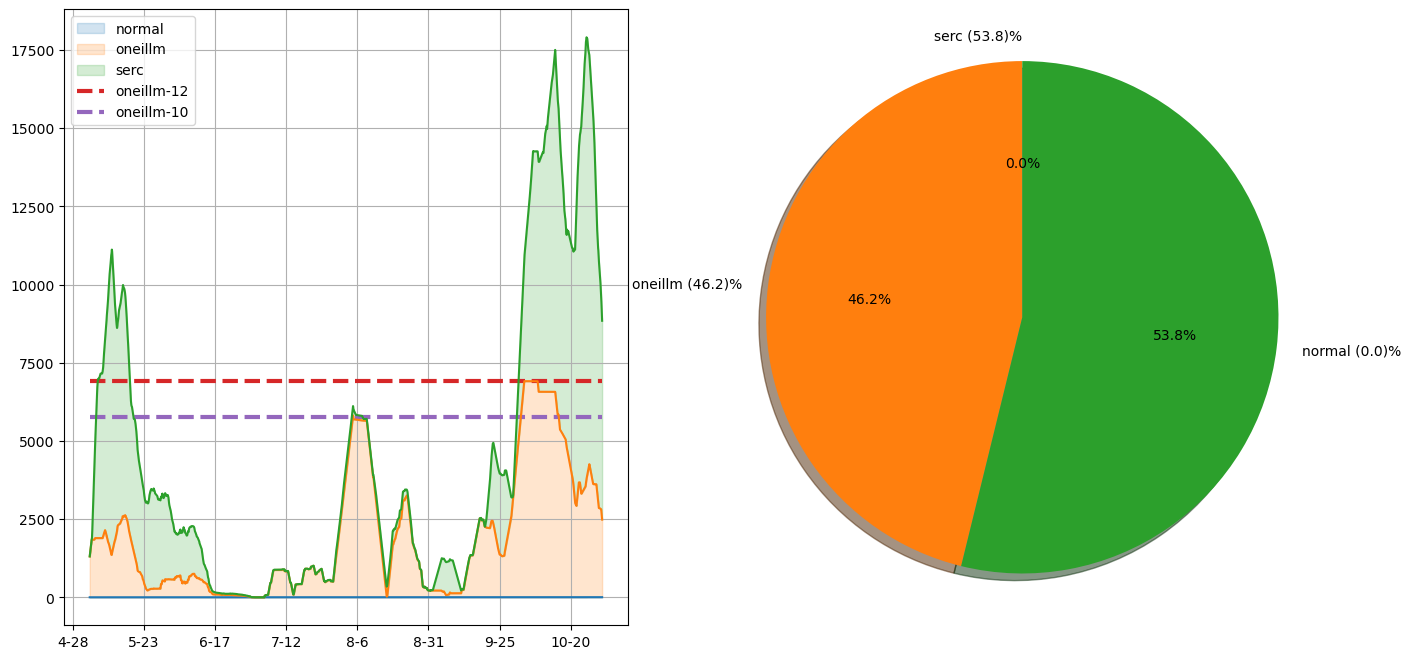

In [20]:
# CPU hours partition-layer cake.
# NOTE: there are entries with multiple partition values (eg, partition=normal,serc). However, it looks like
#. this will only be for jobs that have not yet run or were canceled, so we should be able to break out partitions.
# NOTE: setting elapsed_time --> cpu_hours_total
#
t_min=mpd.datestr2num('2021-12-01')
t_max=mpd.datestr2num('2022-05-24')
t_min=mpd.date2num(start_date)
t_max=mpd.date2num(end_date)

n_points=5000
my_partitions = []
for ptn in list(set(SACCT_obj.jobs_summary['Partition'])):
    print(f'** partition: {ptn}')
    # TODO: Can we modify the HDF5 handling code to use a str type, not bytes-array b's' type? or reverse --
    #. force bytes array when we load directly?
    if hasattr(ptn,'decode'):
        my_partitions += ptn.decode().split(',')
    else:
        my_partitions += ptn.split(',')
    
my_partitions = {ky:{} for ky in list(set(my_partitions))}
print(f'*** my_partitions: {my_partitions}')
#
cpu_hours_total = {}
for ptn in my_partitions.keys():
    print('** ', ptn)
    #
    if hasattr(SACCT_obj.jobs_summary['Partition'][0], 'decode'):
        ix = (SACCT_obj.jobs_summary['Partition'] == ptn.encode())
    else:
        ix = (SACCT_obj.jobs_summary['Partition'] == ptn)
    #
    #print('*** ix: ', ix[0:30])
    my_partitions[ptn]['cpuhours_weekly'] = SACCT_obj.get_cpu_hours(bin_size=7., n_points=n_points,
                                                t_min=t_min, t_max=t_max,
                                                jobs_summary=SACCT_obj.jobs_summary[ix])
    #
    #elapsed_times[ptn] = numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix])
    cpu_hours_total[ptn] = numpy.sum( (SACCT_obj.jobs_summary['Elapsed'][ix])*(SACCT_obj.jobs_summary['NCPUS'][ix]) )
#
fg = plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.grid()
#

z = numpy.zeros(n_points)
for k, (ky,vl) in enumerate(sorted(my_partitions.items(), key=lambda x: x[0]) ):
    z_prev = z.copy()
    #dz = vl['cpuhours_weekly']['cpu_hours']/7.
    dz = vl['cpuhours_weekly']['cpu_hours']
    z += dz
    ln, = ax1.plot(vl['cpuhours_weekly']['time'], z, ls='-', marker='',
             zorder=11+k)
    clr = ln.get_color()
    ax1.fill_between(vl['cpuhours_weekly']['time'], z_prev, z, color=clr, alpha=.2, label=ky)
    #
    
#
ax1.plot(vl['cpuhours_weekly']['time'][0::n_points-1], numpy.ones(2)*(12*24*24.), ls='--', lw=3, label='oneillm-12')
ax1.plot(vl['cpuhours_weekly']['time'][0::n_points-1], numpy.ones(2)*(10*24*24.), ls='--', lw=3, label='oneillm-10')
fg.canvas.draw()
print('*** lbls: ', [s.get_text() for s in ax1.get_xticklabels()])
lbls = [hpc_lib.simple_date_string(mpd.num2date(max(1, float(s.get_text())) ) )[5:] for s in ax1.get_xticklabels()]
ax1.set_xticklabels(lbls)

ax1.legend(loc=0)
#
lbls,sizes = zip(*cpu_hours_total.items())
norm = numpy.sum(sizes)
#
lbls=list(lbls)
for k,(l,s) in enumerate(cpu_hours_total.items()):
    lbls[k] = f'{l} ({(100.*s/norm):.1f})%'
ax2.pie(sorted(sizes), labels=lbls,shadow=True, startangle=90, autopct='%1.1f%%')
ax2.axis('equal')
    

In [29]:
print('** dtype:\n', SACCT_obj.jobs_summary.dtype)
#
#user_cols  = ['Timelimit', 'NCPUS', 'NNodes', 'TotalCPU','NTasks']
#user_types = ['>f8', '>i8', '>i8', '>f8', '>i8', '>f8']

user_cols = ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']
user_types = ['>i8', '>i8', '>f8', '>f8']
#
user_aggs = numpy.zeros( shape=[len(numpy.unique(SACCT_obj.jobs_summary['User'])),],
                        dtype={'names':user_cols, 'formats':user_types })
#
ix = {usr:numpy.where(SACCT_obj.jobs_summary['User']==usr)[0] 
      for usr in numpy.unique(SACCT_obj.jobs_summary['User'])}
#

** dtype:
 [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('Account', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('ReqMem', '<f8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'O'), ('Suspended', 'O'), ('ReqTRES', 'O'), ('AllocTRES', 'O'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent', 'O'), ('NGPUs', '<i8')]


In [30]:
print('*** ', user_aggs.shape, user_aggs.dtype)
print('*** ', user_cols)
user_names = numpy.unique(SACCT_obj.jobs_summary['User'])
for k,user in enumerate(user_names):
    #print('** ', [numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    #
    vals = [numpy.sum( numpy.max([numpy.zeros(len(ix[user])), SACCT_obj.jobs_summary[cl][ix[user]]], axis=0) ) 
                      for cl in user_cols[:-1]]
    vals += [numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix[user]]*24. * SACCT_obj.jobs_summary['NCPUS'][ix[user]])]
    #print('** ix: ', ix[user])
    #vals = [numpy.sum( (SACCT_obj.jobs_summary[cl][ numpy.array(ix[user])] ) )
    #        for cl in user_cols]
    #print('** vals: ', vals)
    
    #user_aggs[user_cols][k] = tuple([numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    
    user_aggs[user_cols][k] = tuple( vals )
    #user_aggs[user_cols][k] = tuple(vals)



***  (7,) [('NCPUS', '>i8'), ('NNodes', '>i8'), ('Elapsed', '>f8'), ('Comp_Vol', '>f8')]
***  ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']


In [31]:
# print('** user, {}'.format(user_cols ) )
# for nm,rw in zip(user_names, user_aggs):
#     print('** {}: {}, '.format(nm,rw))

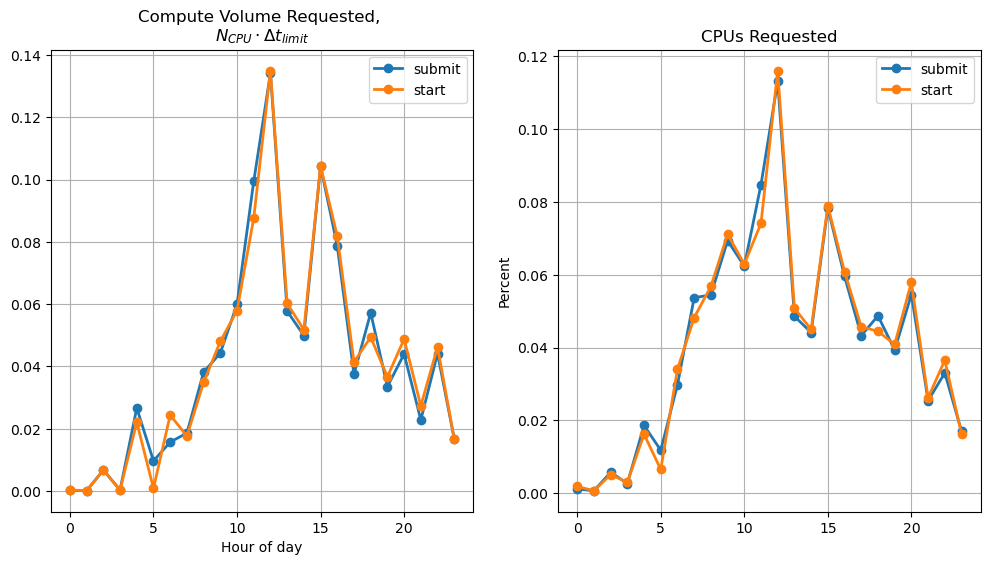

In [52]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
ax1.grid()
ax2.grid()
#

ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time']),
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))

ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time']),
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time'])))
#
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/numpy.sum(comp_vol_submit['cpus']), ls='-', marker='o', lw=2., label='submit')
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/numpy.sum(comp_vol_start['cpus']), ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Percent')

ax2.set_title('CPUs Requested')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

***  ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


Text(0.5, 1.0, '(Cumulative)')

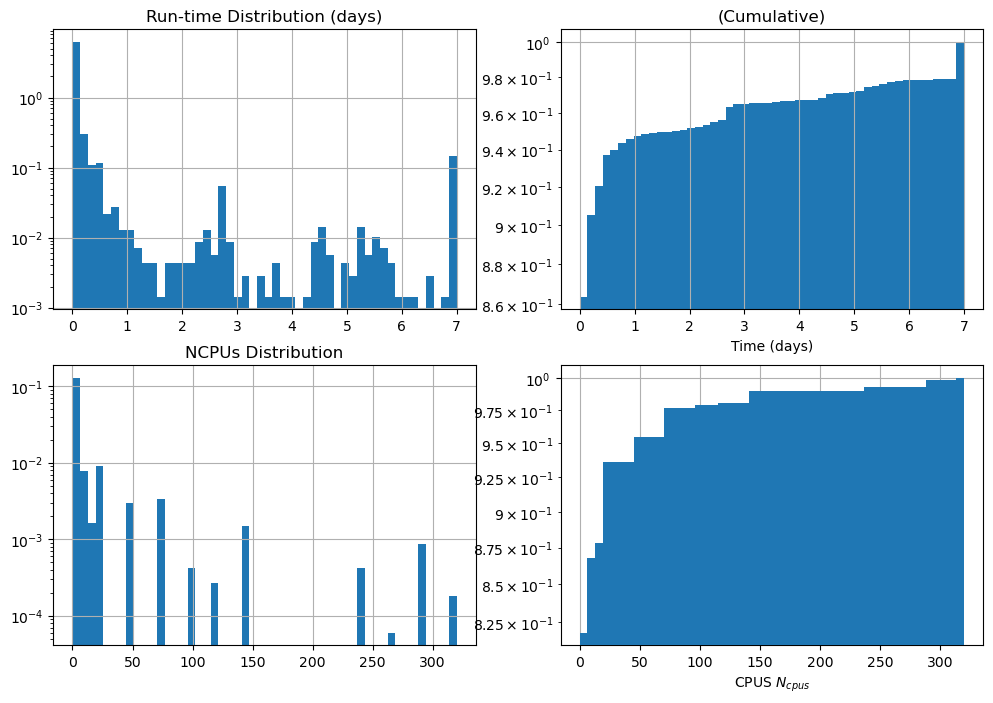

In [33]:
# compute some distributions:
print('*** ', SACCT_obj.jobs_summary.dtype.names)
run_times = SACCT_obj.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
#ax1a.set_yscale('log')
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, density=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, density=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True)
hh22 = ax4.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [34]:
print('** ', len(run_times), len(SACCT_obj.jobs_summary['NCPUS']))

**  4980 5207


In [35]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(SACCT_obj.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


*** quantiles for t=2,7,14 days: 0.951004016064257, 0.979718875502008, 1.0
*** N_24/N=0.9785140562248996


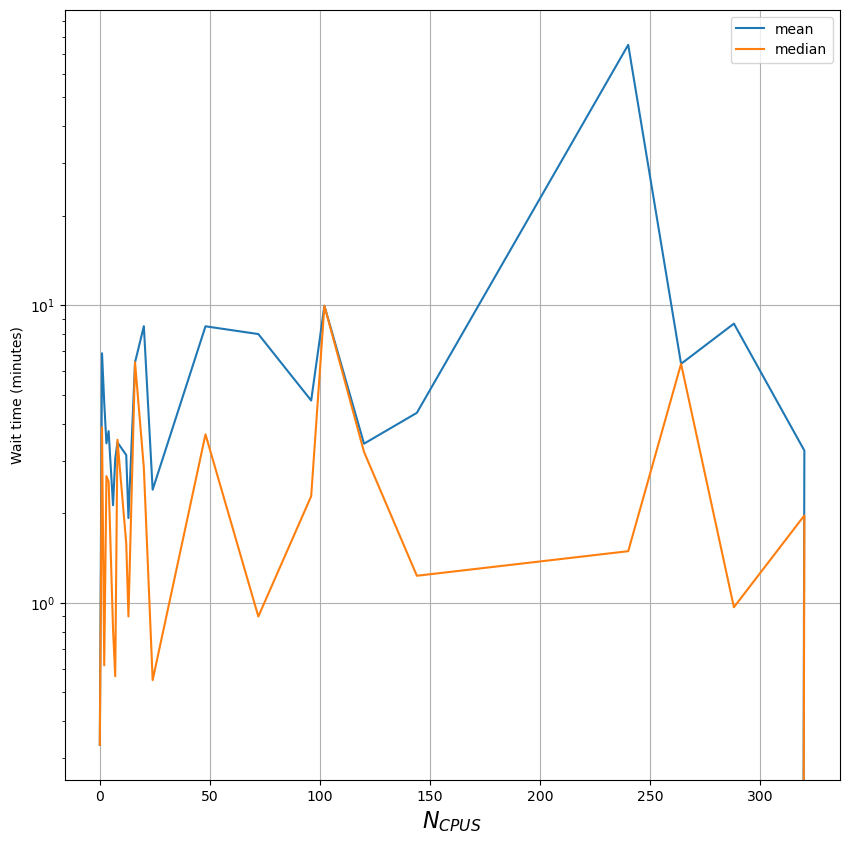

In [36]:
wait_stats = SACCT_obj.get_wait_stats(qs=[.25, .5, .75, .9])
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean']*60.*24, ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median']*60.*24, ls='-', label='median')
#
ax1.set_ylabel('Wait time (minutes)')
ax1.set_xlabel('$N_{CPUS}$', size=16)
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')
ax1.legend(loc=0)

In [41]:
#SACCT_serc = hpc_lib.SACCT_data_from_h5('sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5', keep_raw_data=False, n_cpu=n_cpus)

**  ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')
***  oneillm
***  ['arunbk' 'elbseitz' 'haofu' 'ipshi91' 'oneillm' 'osamum' 'regirock']
*** 100: 0.0002777778427116573 - 0.0002777778427116573 
*** 200: 0.0002777778427116573 - 0.0002777778427116573 
*** 300: 0.06278888889122755 - 0.15390555559366476 
*** 400: 0.0 - 0.0 
*** 500: 0.0 - 0.0 


/home/groups/sh_s-dss/share/sdss/software/x86_64_arch/anaconda/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


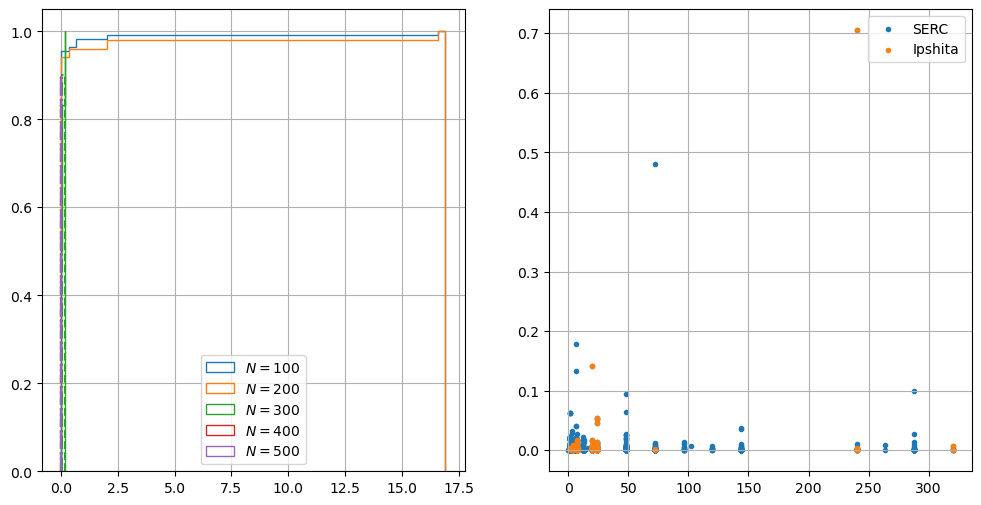

In [42]:
print('** ', SACCT_obj.jobs_summary.dtype.names)
print('*** ', SACCT_obj.group)
print('*** ', numpy.unique(SACCT_obj['User']))
#print('** ', SACCT_obj['NCPUS'])
#
ix_onm  = numpy.logical_and(SACCT_obj['User'].astype(str)=='ipshi91', 
                            SACCT_obj['Partition'].astype(str)=='oneillm')
ix_serc = numpy.logical_and(SACCT_obj['User'].astype(str)=='ipshi91', 
                            SACCT_obj['Partition'].astype(str)=='serc')
ix_ip = SACCT_obj['User'].astype(str)=='ipshi91'
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
#
#hh = ax1.hist(SACCT_obj['NCPUS'][ix_onm], bins=25)
# ax2.scatter(SACCT_obj['NCPUS'][ix_onm], (SACCT_obj['Start'][ix_onm]-SACCT_obj['Submit'][ix_onm]),
#             marker='.', label='oneillm')
# ax2.scatter(SACCT_obj['NCPUS'][ix_serc], (SACCT_obj['Start'][ix_serc]-SACCT_obj['Submit'][ix_serc]),
#             marker='.', label='serc')

#hh = ax1.hist((SACCT_serc['Start'][ix_ip]-SACCT_serc['Submit'][ix_ip]), bins=10)
for n in (100, 200, 300, 400, 500):
    hh = ax1.hist(24.*(SACCT_obj['Start']-SACCT_obj['Submit'])[SACCT_obj['NCPUS']>=n], 
                  bins=50, histtype='step', label=f'$N={n}$', density=True, cumulative=True)
    
    clr = hh[2][0].get_edgecolor()
    
    k = numpy.searchsorted(hh[0], .9)
    x1 = hh[1][k]
    ax1.plot([x1,x1, 0], [0., .9, .9], ls='--', color=clr)
    
    k = numpy.searchsorted(hh[0], .75)
    x2 = hh[1][k]
    ax1.plot([x2,x2, 0], [0., .9, .9], ls='-.', color=clr)
    #
    print(f'*** {n}: {x2} - {x1} ')
    
ax2.scatter(SACCT_obj['NCPUS'], (SACCT_obj['Start']-SACCT_obj['Submit']),
            marker='.', label='SERC')
ax2.scatter(SACCT_obj['NCPUS'][ix_ip], (SACCT_obj['Start'][ix_ip]-SACCT_obj['Submit'][ix_ip]),
            marker='.', label='Ipshita')
ax1.grid()
ax2.grid()
#ax2.set_ylim(-.1, 1.)
ax1.legend(loc=0)
ax2.legend(loc=0)

In [44]:
SACCT_serc = SACCT_obj
print('*** ', numpy.unique(SACCT_oneillm['State']))
print('*** ', numpy.unique(SACCT_serc['State']))
print('*** ', numpy.unique(SACCT_obj['State']))
#
print(f'** oneillm: start={SACCT_oneillm.start_date}, end={SACCT_obj.end_date}')
#
def job_states(states):
    out_states={}
    #
    for s in numpy.array(states).astype(str):
        if s.startswith('CANCELLED'):
            s = 'CANCELLED'
        if not s in out_states.keys():
            out_states[s] = 0
        #
        out_states[s] += 1
    return out_states
#
states_onmp  = job_states(SACCT_oneillm['State'])
states_onmg  = job_states(SACCT_obj['State'][SACCT_obj['Partition'].astype(str)=='serc'])
#
print('\n\n Job States on ONEILLM partition and group(serc): ')
print('** onmp: ', states_onmp)
print('** onmg: ', states_onmg)


***  ['CANCELLED' 'CANCELLED_by_328022' 'CANCELLED_by_333190'
 'CANCELLED_by_333673' 'CANCELLED_by_334253' 'CANCELLED_by_394499'
 'CANCELLED_by_398' 'COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'RUNNING'
 'TIMEOUT']
***  ['CANCELLED' 'CANCELLED_by_328022' 'CANCELLED_by_330160'
 'CANCELLED_by_333190' 'CANCELLED_by_333673' 'CANCELLED_by_334253'
 'CANCELLED_by_394499' 'CANCELLED_by_398' 'CANCELLED_by_419403'
 'COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'RUNNING' 'TIMEOUT']
***  ['CANCELLED' 'CANCELLED_by_328022' 'CANCELLED_by_330160'
 'CANCELLED_by_333190' 'CANCELLED_by_333673' 'CANCELLED_by_334253'
 'CANCELLED_by_394499' 'CANCELLED_by_398' 'CANCELLED_by_419403'
 'COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'RUNNING' 'TIMEOUT']
** oneillm: start=2023-05-04 00:00:00+00:00, end=2023-10-31 00:00:00+00:00


 Job States on ONEILLM partition and group(serc): 
** onmp:  {'COMPLETED': 2292, 'FAILED': 437, 'CANCELLED': 651, 'TIMEOUT': 105, 'OUT_OF_MEMORY': 1, 'RUNNING': 1}
** onmg:  {'COMPLETED': 886, 'TIMEOUT': 176, 'F

In [45]:
ix = numpy.logical_and((SACCT_obj['User']=='ipshi91'.encode()), SACCT_obj['NCPUS']>=100)
print('** ', numpy.sum(SACCT_obj['User']=='ipshi91'.encode()))
#flds = ['Partition', 'State', 'NCPUS', 'NNodes', 'Submit', 'Start', 'End', 'Elapsed', 'NTasks', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize' ]
flds = ['Partition', 'State', 'NCPUS', 'NNodes', 'NTasks', 'Submit', 'Start'] 
#
for rw in SACCT_obj[flds][ix]:
    print('** ', rw, None if rw['Start'] is None else rw['Start']-rw['Submit'])


**  0


In [46]:
#print('** ', numpy.unique())
flds = ['Partition', 'State', 'NCPUS', 'NNodes', 'NTasks']
for rw in SACCT_obj[flds][SACCT_obj['User']=='ipshi91'.encode()]:
    print('** ', rw)


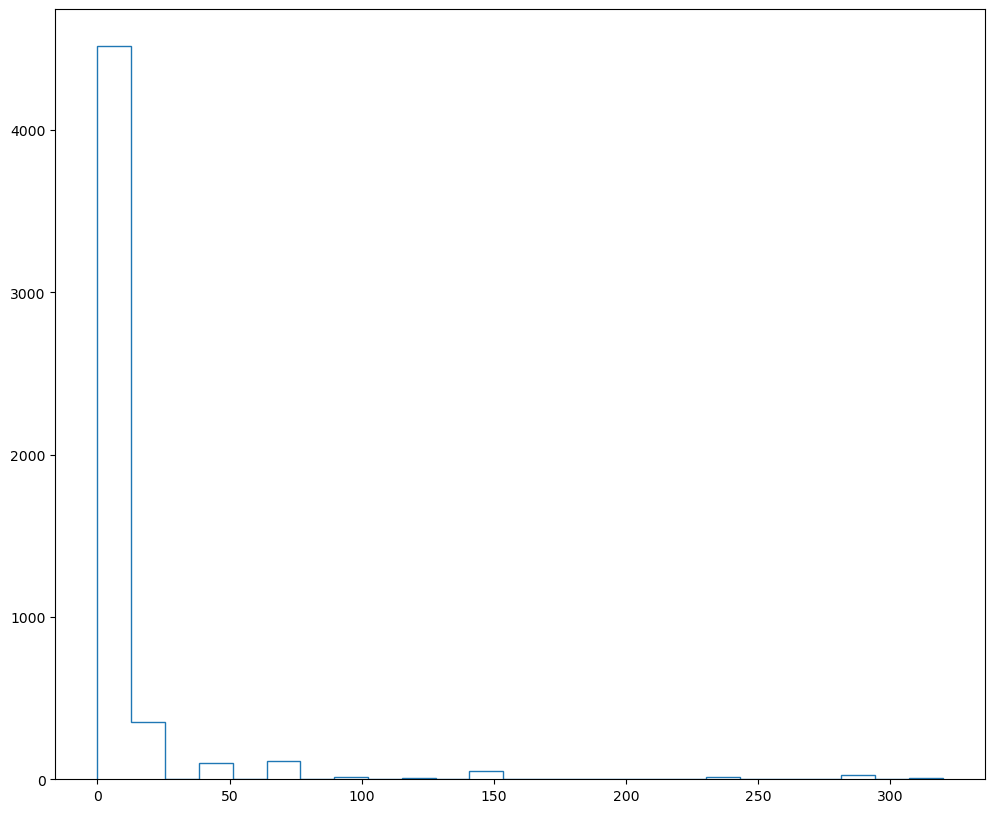

In [47]:
fg = plt.figure(figsize=(12,10))
ax1 = fg.add_subplot(1,1,1)
#
hh = ax1.hist(SACCT_obj['NCPUS'], bins=25, histtype='step')

24.0